In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import clear_output

In [21]:
sns.set(rc = {
    'axes.facecolor':'#1e1e1e',
    'axes.edgecolor': 'grey',
    'text.color': 'grey',
    'figure.facecolor':'#1e1e1e',
    'axes.labelcolor': 'grey',
    'xtick.color': 'grey',
    'ytick.color': 'grey',
    'grid.color': 'grey',
    'grid.linestyle': 'dotted',
})

<center>
    <hr>
    <h1>Cleaning Data</h1>
    <hr>
</center>

<a id='the_destination'></a> 

## Defining cleaning functions

In [22]:
def empty_columns(df, percentage = 0.9):
    '''
        Delete columns with a certain percentage (default is 90%) of missing values
    '''
    empty = []
    for col in df.columns:
        if df[col].isna().sum() >= df.shape[0]*0.9:
            empty.append(col)
    return empty

## Reading csv files

In [ ]:
Assure = pd.read_csv('../Data/assure.csv', sep = ';')
BonusMalus = pd.read_csv('../Data/classBonusMalus.csv', sep = ';')
Epave = pd.read_csv('../Data/epave.csv', sep = ";")
Marque = pd.read_excel('../Data/marque.xlsx', sep = ';')
Police = pd.read_csv('../Data/Police.csv', sep = ';')
Sinistre = pd.read_csv('../Data/Sinistre.csv', sep = ';')
Usage = pd.read_excel('../Data/Usage.xlsx', sep = ';')
UsageCGA = pd.read_csv('../Data/UsageCGA.csv', sep = ';')
Vehicule = pd.read_csv('../Data/vehicule.csv', sep = ';')

<center>
    <h1>[Common treatment]</h1>
</center>

## Deleting empty columns

In [5]:
Assure.drop(columns = empty_columns(Assure), inplace = True) ##########
BonusMalus.drop(columns = empty_columns(BonusMalus), inplace = True) ##########
Epave.drop(columns = empty_columns(Epave), inplace = True)
Marque.drop(columns = empty_columns(Marque), inplace = True) ##########
Police.drop(columns = empty_columns(Police), inplace = True) ##########
Sinistre.drop(columns = empty_columns(Sinistre), inplace = True) ##########
Usage.drop(columns = empty_columns(Usage), inplace = True) ##########
UsageCGA.drop(columns = empty_columns(UsageCGA), inplace = True)
Vehicule.drop(columns = empty_columns(Vehicule), inplace = True) ##########

## Deleting duplicates

In [6]:
Assure.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
BonusMalus.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
Epave.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
Marque.drop_duplicates(subset = ['CD_MARQ'], keep = 'first', inplace = True)
Police.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
Sinistre.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
Usage.drop_duplicates(subset = ['CD_USAGE'], keep = 'first', inplace = True)
UsageCGA.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
Vehicule.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)

<center>
    <h1>[Assure]</h1>
</center>

## $\rightarrow$ Overview

In [7]:
Assure.head()

,id,codeTypePieceIdentite,DATE_OBTENTION,codePostal
0,1378074,1,24/04/02,2080.0
1,28443,1,17/07/82,1110.0
2,886858,1,07/03/83,1068.0
3,1091556,1,29/06/82,NaN
4,894479,1,27/04/83,2052.0


In [8]:
print(Assure.isna().sum())
print('-'*50)
print('Dataframe shape : ' + str(Assure.shape))

id                         0
codeTypePieceIdentite      0
DATE_OBTENTION             0
codePostal               715
dtype: int64
--------------------------------------------------
Dataframe shape : (34357, 4)


## $\rightarrow$ Dropping data
### 715 is only 2% of the information

In [9]:
Assure.dropna(inplace = True)

## $\rightarrow$ Structuring columns : `DATE_OBTENTION`

In [10]:
tmp = Assure['DATE_OBTENTION'].values
for i in range(len(tmp)):
    date_list = tmp[i].split('/')
    if int(date_list[2]) > 19:
        date_list[2] = '19' + str(date_list[2])
    else:
        date_list[2] = '20' + str(date_list[2])
    tmp[i] = '-'.join(date_list)
Assure['DATE_OBTENTION'] = tmp

## $\rightarrow$ Adding derivative columns : `gouvernorat`
### Dropping `codePostal` as well

In [11]:
# Reading xls file
codePostal = pd.read_excel('../Data/codepostal.xls', header = None, index_col = 2).drop(columns = [1])

# Adding codePosatl column
codeP = codePostal.to_dict()[0]

gov = []
for line in range(Assure.shape[0]):
    if Assure.iloc[line, -1] in codeP.keys():
        gov.append(codeP[Assure.iloc[line, -1]])
    else:
        gov.append('-')
        
Assure['gouvernorat'] = gov
Assure.replace({'gouvernorat': '-'}, np.NaN, inplace = True)

# Replacing missing values with last value
Assure['gouvernorat'] = Assure['gouvernorat'].fillna(method = 'backfill')

# Dropping codePostal
Assure.drop(columns = ['codePostal'], inplace = True)

Assure.head()

,id,codeTypePieceIdentite,DATE_OBTENTION,gouvernorat
0,1378074,1,24-04-2002,Ariana
1,28443,1,17-07-1982,Manouba
2,886858,1,07-03-1983,Tunis
4,894479,1,27-04-1983,Tunis
5,180741,1,01-12-1982,Tunis


## $\rightarrow$ Renaming columns

In [12]:
Assure.rename(columns = {
    'id': 'assureId',
    'DATE_OBTENTION': 'dateObtentionPermis'
}, inplace = True)

Assure.head()

,assureId,codeTypePieceIdentite,dateObtentionPermis,gouvernorat
0,1378074,1,24-04-2002,Ariana
1,28443,1,17-07-1982,Manouba
2,886858,1,07-03-1983,Tunis
4,894479,1,27-04-1983,Tunis
5,180741,1,01-12-1982,Tunis


<center>
    <h1>[BonusMalus]</h1>
</center>

## $\rightarrow$ Overview

In [13]:
BonusMalus.head()

,id,police_id,vehicule_id,assure_id,souscripteur_id,classeBonusMalus,classeBonusMalusCompagnie,classeBonusMalusCGA,coefBonusMalus,coefBonusMalusCompagnie,coefBonusMalusCGA,DATE_AFFECTATION,CONTRAT_EN_COURS,bonus,ETAT_VEHICULE,date_Calcule,date_Occurence,dernierClassBonusMallus,codeUsage
0,32696,32700,29293,26960,26960,3,3,3,100,100.0,100,2017-05-11 00:00:00.000000,1,0,V,2016-05-11 00:00:00.000000,2016-05-11 00:00:00.000000,1,10
1,33346,33350,28891,26553,26553,1,1,1,80,80.0,80,2017-08-18 00:00:00.000000,1,0,V,2016-08-18 00:00:00.000000,2016-08-18 00:00:00.000000,1,10
2,33482,33486,29087,26754,26754,2,2,2,90,90.0,90,2016-09-20 00:00:00.000000,1,0,V,2016-09-20 00:00:00.000000,2016-09-20 00:00:00.000000,1,10
3,33496,33500,30651,28321,28321,1,1,1,80,80.0,80,2017-11-11 00:00:00.000000,1,0,V,2016-11-11 00:00:00.000000,2016-11-11 00:00:00.000000,1,10
4,33732,33736,30930,28600,28600,1,1,1,80,80.0,80,2016-11-14 00:00:00.000000,1,0,V,2016-11-14 00:00:00.000000,2016-11-14 00:00:00.000000,1,10


In [14]:
print(BonusMalus.isna().sum())
print('-'*50)
print('Dataframe shape : ' + str(BonusMalus.shape))

id                               0
police_id                        0
vehicule_id                      0
assure_id                        0
souscripteur_id                  0
classeBonusMalus                 0
classeBonusMalusCompagnie        0
classeBonusMalusCGA              0
coefBonusMalus                   0
coefBonusMalusCompagnie          1
coefBonusMalusCGA                0
DATE_AFFECTATION                 0
CONTRAT_EN_COURS                 0
bonus                            0
ETAT_VEHICULE                    0
date_Calcule                     0
date_Occurence               12461
dernierClassBonusMallus          0
codeUsage                        0
dtype: int64
--------------------------------------------------
Dataframe shape : (93142, 19)


## $\rightarrow$ Dropping useless columns
- souscripteur_id
- classeBonusMalusCompagnie
- classeBonusMalusCGA
- coefBonusMalusCompagnie
- coefBonusMalusCGA
- bonus
- date_Calcule
- date_Occurence

In [15]:
BonusMalus.drop(columns = ['souscripteur_id', 'classeBonusMalusCompagnie', 'classeBonusMalusCGA', 'coefBonusMalusCompagnie', 
                           'coefBonusMalusCGA', 'bonus', 'date_Calcule', 'date_Occurence'], inplace = True)

## $\rightarrow$ Structuring columns : `DATE_AFFECTATION`

In [16]:
BonusMalus['DATE_AFFECTATION'] = BonusMalus['DATE_AFFECTATION'].str.replace(' 00:00:00.000000', '')

BonusMalus.head()

,id,police_id,vehicule_id,assure_id,classeBonusMalus,coefBonusMalus,DATE_AFFECTATION,CONTRAT_EN_COURS,ETAT_VEHICULE,dernierClassBonusMallus,codeUsage
0,32696,32700,29293,26960,3,100,2017-05-11,1,V,1,10
1,33346,33350,28891,26553,1,80,2017-08-18,1,V,1,10
2,33482,33486,29087,26754,2,90,2016-09-20,1,V,1,10
3,33496,33500,30651,28321,1,80,2017-11-11,1,V,1,10
4,33732,33736,30930,28600,1,80,2016-11-14,1,V,1,10


## $\rightarrow$ Renaming columns

In [17]:
BonusMalus.rename(columns = {
    'id': 'bonusMalusId',
    'police_id': 'policeId',
    'vehicule_id': 'vehiculeId',
    'assure_id': 'assureId',
    'DATE_AFFECTATION': 'dateAffectation',
    'CONTRAT_EN_COURS': 'contratEnCours',
    'ETAT_VEHICULE': 'etatVehicule',
    'dernierClassBonusMallus': 'derniereClasseBonusMalus'
}, inplace = True)

BonusMalus.head()

,bonusMalusId,policeId,vehiculeId,assureId,classeBonusMalus,coefBonusMalus,dateAffectation,contratEnCours,etatVehicule,derniereClasseBonusMalus,codeUsage
0,32696,32700,29293,26960,3,100,2017-05-11,1,V,1,10
1,33346,33350,28891,26553,1,80,2017-08-18,1,V,1,10
2,33482,33486,29087,26754,2,90,2016-09-20,1,V,1,10
3,33496,33500,30651,28321,1,80,2017-11-11,1,V,1,10
4,33732,33736,30930,28600,1,80,2016-11-14,1,V,1,10


<center>
    <h1>[Marque]</h1>
</center>

## $\rightarrow$ Overview

In [18]:
Marque.head()

,CD_MARQ,CD_CONST,CD_MARQ_CH,DESIGL,DESIGA,DDEB,DFIN,OBSERV
0,53,53,53,KENWORTH,كانورث,20/03/56,24/02/56,Recuperation effectuee lors de l'Operation de ...
1,54,54,54,IFA,إيفا,20/03/56,24/02/56,Recuperation effectuee lors de l'Operation de ...
2,55,55,55,WORDSWORTH HOLDINGS,وردورث هولدينك,20/03/56,24/02/56,Recuperation effectuee lors de l'Operation de ...
3,56,56,56,SERMIT,سرميت,20/03/56,24/02/56,Recuperation effectuee lors de l'Operation de ...
4,57,57,57,PETTIBONE,بتوبون,20/03/56,24/02/56,Recuperation effectuee lors de l'Operation de ...


In [19]:
print(Marque.isna().sum())
print('-'*50)
print('Dataframe shape : ' + str(Marque.shape))

CD_MARQ         0
CD_CONST        0
CD_MARQ_CH    912
DESIGL          0
DESIGA        741
DDEB            0
DFIN            0
OBSERV        918
dtype: int64
--------------------------------------------------
Dataframe shape : (1913, 8)


## $\rightarrow$ Dropping useless columns
- CD_CONST
- CD_MARQ_CH
- DESIGA
- DDEB
- DFIN
- OBSERV

In [20]:
Marque.drop(columns = ['CD_CONST', 'CD_MARQ_CH', 'DESIGA', 'DDEB', 'DFIN', 'OBSERV'], inplace = True)

## $\rightarrow$ Renaming columns

In [21]:
Marque.rename(columns = {
    'CD_MARQ': 'codeMarque',
    'DESIGL': 'marque'
}, inplace = True)

Marque.head()

,codeMarque,marque
0,53,KENWORTH
1,54,IFA
2,55,WORDSWORTH HOLDINGS
3,56,SERMIT
4,57,PETTIBONE


<center>
    <h1>[Police]</h1>
</center>

## $\rightarrow$ Overview

In [22]:
Police.head()

,id,codeCompagnie,codeAgence,typeIntermediaire,numPolice,naturePolice,typePolice,dateEffetPolice,dateEcheancePolice,verouillageModifPolice,Etat_Police,DATE_RESILIATION
0,61519,8,19,1,10030000605,T,I,2016-04-17,NaN,0,V,NaN
1,61553,8,90,1,10080000042,R,I,2016-04-21,421.0,0,V,NaN
2,61587,8,71,3,10050000959,R,I,2016-04-26,426.0,0,V,NaN
3,61787,8,13,1,10010005016,R,I,2016-05-27,527.0,0,V,NaN
4,61796,8,36,1,10020003342,R,I,2016-05-27,527.0,0,V,NaN


In [23]:
print(Police.isna().sum())
print('-'*50)
print('Dataframe shape : ' + str(Police.shape))

id                            0
codeCompagnie                 0
codeAgence                    0
typeIntermediaire             0
numPolice                     0
naturePolice                  0
typePolice                    0
dateEffetPolice               0
dateEcheancePolice         2922
verouillageModifPolice        0
Etat_Police                   0
DATE_RESILIATION          82570
dtype: int64
--------------------------------------------------
Dataframe shape : (94620, 12)


## $\rightarrow$ Dropping useless columns
- typeIntermediaire
- numPolice
- verouillageModifPolice

In [24]:
Police.drop(columns = ['typeIntermediaire', 'numPolice', 'verouillageModifPolice', 'dateEcheancePolice'], inplace = True)

## $\rightarrow$ Adding derivative columns : `resiliation`
### Dropping `DATE_RESILIATION` as well

In [25]:
resiliation = []
for date in Police['DATE_RESILIATION'].values:
    if str(date) == 'nan':
        resiliation.append(0)
    else:
        resiliation.append(1)

Police['resiliation'] = resiliation

Police.drop(columns = ['DATE_RESILIATION'], inplace = True)

Police.head()

,id,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,Etat_Police,resiliation
0,61519,8,19,T,I,2016-04-17,V,0
1,61553,8,90,R,I,2016-04-21,V,0
2,61587,8,71,R,I,2016-04-26,V,0
3,61787,8,13,R,I,2016-05-27,V,0
4,61796,8,36,R,I,2016-05-27,V,0


## $\rightarrow$ Renaming columns

In [26]:
Police.rename(columns = {
    'id': 'policeId',
    'Etat_Police': 'etatPolice'
}, inplace = True)

Police.head()

,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation
0,61519,8,19,T,I,2016-04-17,V,0
1,61553,8,90,R,I,2016-04-21,V,0
2,61587,8,71,R,I,2016-04-26,V,0
3,61787,8,13,R,I,2016-05-27,V,0
4,61796,8,36,R,I,2016-05-27,V,0


<center>
    <h1>[Sinistre]</h1>
</center>

## $\rightarrow$ Overview

In [27]:
Sinistre.head()

,id,sinistre_id,cga_police_id,cga_vehicule_id,cga_assure_id,numeroDuSinistre,dateDeSurvenanceDuSinistre,heureSurvanceDusinistre,dateOuvertureDuSinistre,lieuDuSinistre,identificationTiers,pourcentadeDeResponsabilite,numeroDePoliceCompagnieAdverse,codeCompagnieAdverse,porcentageCompagnieAdverse,numeroImmatriculationVehiculeAdverse,typeImmatriculationVehiculeAdverse,mouvementDusinistre,natureDuSinistre,Calculer_Sinistre
0,2,2,174557,166073,144565,S170155501,2017-12-18,0,2017-12-18,NaN,NaN,100,834736,11.0,0,1651TU133,TU,3,M,0
1,4,4,174560,17936,119709,S170032921,2017-03-11,0,2017-03-27,NaN,NaN,100,010204000027,4.0,0,3626TU159,TU,3,M,0
2,5,5,174573,17192,144580,S170144161,2017-11-23,0,2017-11-27,NaN,NaN,0,0101160000565,4.0,0,8312TU163,TU,3,M,0
3,6,6,174581,166084,135912,S170022571,2017-02-23,0,2017-03-02,NaN,NaN,0,20075.0336001/3,1.0,0,9213TU96,TU,3,M,0
4,7,7,174591,21767,144597,S170095321,2017-08-08,0,2017-08-10,NaN,NaN,0,505311517,14.0,0,4848TU97,TU,3,M,0


In [28]:
print(Sinistre.isna().sum())
print('-'*50)
print('Dataframe shape : ' + str(Sinistre.shape))

id                                          0
sinistre_id                                 0
cga_police_id                               0
cga_vehicule_id                             0
cga_assure_id                               0
numeroDuSinistre                            0
dateDeSurvenanceDuSinistre                  0
heureSurvanceDusinistre                     0
dateOuvertureDuSinistre                     0
lieuDuSinistre                          13320
identificationTiers                     18707
pourcentadeDeResponsabilite                 0
numeroDePoliceCompagnieAdverse              0
codeCompagnieAdverse                      120
porcentageCompagnieAdverse                  0
numeroImmatriculationVehiculeAdverse     3178
typeImmatriculationVehiculeAdverse       2712
mouvementDusinistre                         0
natureDuSinistre                            0
Calculer_Sinistre                           0
dtype: int64
--------------------------------------------------
Dataframe shape 

## $\rightarrow$ Dropping useless columns
- sinistre_id (equal to id)
- numeroDuSinistre
- identificationTiers
- numeroImmatriculationVehiculeAdverse
- typeImmatriculationVehiculeAdverse
- mouvementDuSinistre
- Calculer_Sinistre
- porcentageCompagnieAdverse
- codeCompagnieAdverse
- numeroDePoliceCompagnieAdverse

In [29]:
Sinistre.drop(columns = ['sinistre_id', 'numeroDuSinistre', 'numeroImmatriculationVehiculeAdverse', 'typeImmatriculationVehiculeAdverse',       
                         'mouvementDusinistre', 'Calculer_Sinistre', 'identificationTiers', 'porcentageCompagnieAdverse', 
                         'codeCompagnieAdverse', 'numeroDePoliceCompagnieAdverse'], inplace = True)

In [30]:
print(Sinistre.isna().sum())
print('-'*50)
print('Dataframe shape : ' + str(Sinistre.shape))

id                                 0
cga_police_id                      0
cga_vehicule_id                    0
cga_assure_id                      0
dateDeSurvenanceDuSinistre         0
heureSurvanceDusinistre            0
dateOuvertureDuSinistre            0
lieuDuSinistre                 13320
pourcentadeDeResponsabilite        0
natureDuSinistre                   0
dtype: int64
--------------------------------------------------
Dataframe shape : (30000, 10)


## $\rightarrow$ Renaming columns

In [31]:
Sinistre.rename(columns = {
    'id': 'sinistreId',
    'cga_police_id': 'policeId',
    'cga_vehicule_id': 'vehiculeId',
    'cga_assure_id': 'assureId',
    'heureSurvanceDusinistre': 'heureDeSurvenanceDuSinistre',
    'pourcentadeDeResponsabilite': 'pourcentageDeResponsabilite',
}, inplace = True)

Sinistre.head()

,sinistreId,policeId,vehiculeId,assureId,dateDeSurvenanceDuSinistre,heureDeSurvenanceDuSinistre,dateOuvertureDuSinistre,lieuDuSinistre,pourcentageDeResponsabilite,natureDuSinistre
0,2,174557,166073,144565,2017-12-18,0,2017-12-18,NaN,100,M
1,4,174560,17936,119709,2017-03-11,0,2017-03-27,NaN,100,M
2,5,174573,17192,144580,2017-11-23,0,2017-11-27,NaN,0,M
3,6,174581,166084,135912,2017-02-23,0,2017-03-02,NaN,0,M
4,7,174591,21767,144597,2017-08-08,0,2017-08-10,NaN,0,M


<center>
    <h1>[Vehicule]</h1>
</center>

## $\rightarrow$ Overview

In [32]:
Vehicule.head()

,id,numChassis,codeMarque,puissanceFiscal,numImmatriculation,typeImmatriculation,energie,dateInsertion,dateAjout,etatVehicule
0,79650,VSSZZZ5FZGR094260,206,6.0,53TU189,TU,ESSENCE,2017-10-05,2018-02-14 15:37:47.000000,V
1,79684,KNADN411AG6664007,808,5.0,820TU189,TU,ESSENCE,2017-10-05,2018-02-14 15:38:14.000000,V
2,79701,WBAAS71090CK47163,93,8.0,5385TU109,TU,GASOIL,2017-10-05,2018-02-14 15:38:26.000000,V
3,79735,ZFA19900000969468,119,4.0,5463TU167,TU,ESSENCE,2017-10-05,2018-02-14 15:38:53.000000,V
4,79748,WDD2050401F006754,103,8.0,5103TU182,TU,ESSENCE,2017-10-05,2018-02-14 15:39:02.000000,V


In [33]:
print(Vehicule.isna().sum())
print('-'*50)
print('Dataframe shape : ' + str(Vehicule.shape))

id                      0
numChassis              0
codeMarque              0
puissanceFiscal         7
numImmatriculation      0
typeImmatriculation     0
energie                34
dateInsertion           0
dateAjout               0
etatVehicule            0
dtype: int64
--------------------------------------------------
Dataframe shape : (92480, 10)


## $\rightarrow$ Dropping data
### 34 is only 0.03% of the information

In [34]:
Vehicule.dropna(inplace = True)

## $\rightarrow$ Dropping useless columns
- numChassis
- numImmatriculation
- dateInsertion
- dateAjout

In [35]:
Vehicule.drop(columns = ['numChassis', 'numImmatriculation', 'dateInsertion', 'dateAjout'], inplace = True)

## $\rightarrow$ Renaming columns

In [36]:
Vehicule.rename(columns = {
    'id': 'vehiculeId'
}, inplace = True)

Vehicule.head()

,vehiculeId,codeMarque,puissanceFiscal,typeImmatriculation,energie,etatVehicule
0,79650,206,6.0,TU,ESSENCE,V
1,79684,808,5.0,TU,ESSENCE,V
2,79701,93,8.0,TU,GASOIL,V
3,79735,119,4.0,TU,ESSENCE,V
4,79748,103,8.0,TU,ESSENCE,V


<center>
    <h1>[Usage]</h1>
</center>

## $\rightarrow$ Overview

In [37]:
Usage.head()

,CD_USAGE,DESIGL,DESIGA,DDEB,DFIN,DATE_INSERTION
0,211,TRANSPORT FUNERAIRE,نقل جنائز,20/01/16,17/01/26,11/12/17
1,93,FOURGON TRANSPORT DE FONT,صندوق لنقل العملة,16/07/14,22/06/14,11/12/17
2,210,CF/de la conduite automobile,م.مختص/التكوين-سياقة العربات,15/01/16,22/12/15,11/12/17
3,10,-TAXI INDIVIDUEL,"سيارة أجرة ""تـــاكسي""",23/06/99,27/05/09,11/12/17
4,20,-LOUAGE,"سيارة أجرة ""لواج""",23/06/99,27/05/09,11/12/17


In [38]:
print(Usage.isna().sum())
print('-'*50)
print('Dataframe shape : ' + str(Usage.shape))

CD_USAGE          0
DESIGL            0
DESIGA            0
DDEB              0
DFIN              0
DATE_INSERTION    0
dtype: int64
--------------------------------------------------
Dataframe shape : (28, 6)


## $\rightarrow$ Dropping useless columns
- DESIGA
- DDEB
- DFIN
- DATE_INSERTION

In [39]:
Usage.drop(columns = ['DESIGA', 'DDEB', 'DFIN', 'DATE_INSERTION'], inplace = True)

## $\rightarrow$ Renaming columns

In [40]:
Usage.rename(columns = {
    'CD_USAGE': 'codeUsage',
    'DESIGL': 'usage'
}, inplace = True)

Usage.head()

,codeUsage,usage
0,211,TRANSPORT FUNERAIRE
1,93,FOURGON TRANSPORT DE FONT
2,210,CF/de la conduite automobile
3,10,-TAXI INDIVIDUEL
4,20,-LOUAGE


<center>
    <h1>[Epave]</h1>
    TODO
</center>

<center>
    <h1>[UsageCGA]</h1>
</center>

## $\rightarrow$ Overview

In [41]:
UsageCGA.head()

,id,code Usage,lib Usage,ENABLED,CODE_STR
0,776,1,Privé et professionnel,1,5
1,777,2,Agricole1 véhicule dont le PTC < 3500 kg,1,5
2,778,3,Agricole 2 véhicule dont le PTC > 3500 kg,1,5
3,779,4,Agricole Tracteur et Moissonneuse Batteuse,1,5
4,780,5,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...,1,5


In [42]:
print(UsageCGA.isna().sum())
print('-'*50)
print('Dataframe shape : ' + str(UsageCGA.shape))

id            0
code Usage    0
lib Usage     0
ENABLED       0
CODE_STR      0
dtype: int64
--------------------------------------------------
Dataframe shape : (17, 5)


## $\rightarrow$ Dropping useless columns
- id
- ENABLED
- CODE_STR

In [43]:
UsageCGA.drop(columns = ['id', 'ENABLED', 'CODE_STR'], inplace = True)

## $\rightarrow$ Renaming columns

In [44]:
UsageCGA.rename(columns = {
    'code Usage': 'codeUsage',
    'lib Usage': 'usage'
}, inplace = True)

UsageCGA.head()

,codeUsage,usage
0,1,Privé et professionnel
1,2,Agricole1 véhicule dont le PTC < 3500 kg
2,3,Agricole 2 véhicule dont le PTC > 3500 kg
3,4,Agricole Tracteur et Moissonneuse Batteuse
4,5,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...


<center>
    <h1>[Exporting data]</h1>
</center>

In [45]:
Assure.set_index('assureId').to_csv('../Cleaned_Data/Assure.csv')
BonusMalus.set_index('bonusMalusId').to_csv('../Cleaned_Data/BonusMalus.csv')
Marque.set_index('codeMarque').to_csv('../Cleaned_Data/Marque.csv')
Police.set_index('policeId').to_csv('../Cleaned_Data/Police.csv')
Sinistre.set_index('sinistreId').to_csv('../Cleaned_Data/Sinistre.csv')
Vehicule.set_index('vehiculeId').to_csv('../Cleaned_Data/Vehicule.csv')
Usage.set_index('codeUsage').to_csv('../Cleaned_Data/Usage.csv')
UsageCGA.set_index('codeUsage').to_csv('../Cleaned_Data/UsageCGA.csv')

<center>
    <hr>
    <h1>Reducing Tables</h1>
    <hr>
</center>

In [46]:
Assure = pd.read_csv('../Cleaned_Data/Assure.csv')
BonusMalus = pd.read_csv('../Cleaned_Data/BonusMalus.csv')
Epave = pd.read_csv('../Cleaned_Data/Epave.csv')
Marque = pd.read_csv('../Cleaned_Data/Marque.csv')
Police = pd.read_csv('../Cleaned_Data/Police.csv')
Sinistre = pd.read_csv('../Cleaned_Data/Sinistre.csv')
Usage = pd.read_csv('../Cleaned_Data/Usage.csv')
UsageCGA = pd.read_csv('../Cleaned_Data/UsageCGA.csv')
Vehicule = pd.read_csv('../Cleaned_Data/Vehicule.csv')

<center>
    <h1>[Vehicule ~ Marque]</h1>
</center>

In [47]:
poop = Marque.set_index('codeMarque')
Vehicule = Vehicule.join(poop, on = 'codeMarque', how = 'left').drop(columns = ['codeMarque'])

Vehicule.drop_duplicates('vehiculeId', inplace = True)

print(Vehicule.shape)
print('-'*158)
Vehicule.head()

(92446, 6)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,vehiculeId,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque
0,79650,6.0,TU,ESSENCE,V,SEAT
1,79684,5.0,TU,ESSENCE,V,KIA
2,79701,8.0,TU,GASOIL,V,BMW
3,79735,4.0,TU,ESSENCE,V,FIAT
4,79748,8.0,TU,ESSENCE,V,MERCEDES-BENZ


<center>
    <h1>[Vehicule ~ UsageCGA]</h1>
</center>
<h2> Vehicule ~ BonusMalus ~ UsageCGA </h2>

In [48]:
poop = BonusMalus.set_index('vehiculeId')[['codeUsage']]
Vehicule = Vehicule.join(poop, on = 'vehiculeId', how = 'left')

Vehicule.drop_duplicates('vehiculeId', inplace = True)

print(Vehicule.shape)
print('-'*158)
Vehicule.head()

(92446, 7)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,vehiculeId,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,codeUsage
0,79650,6.0,TU,ESSENCE,V,SEAT,1
1,79684,5.0,TU,ESSENCE,V,KIA,1
2,79701,8.0,TU,GASOIL,V,BMW,1
3,79735,4.0,TU,ESSENCE,V,FIAT,1
4,79748,8.0,TU,ESSENCE,V,MERCEDES-BENZ,1


In [49]:
poop = UsageCGA.set_index('codeUsage')
Vehicule = Vehicule.join(poop, on = 'codeUsage', how = 'left').drop(columns = ['codeUsage'])

Vehicule.drop_duplicates('vehiculeId', inplace = True)

print(Vehicule.shape)
print('-'*158)
Vehicule.head()

(92446, 7)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,vehiculeId,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage
0,79650,6.0,TU,ESSENCE,V,SEAT,Privé et professionnel
1,79684,5.0,TU,ESSENCE,V,KIA,Privé et professionnel
2,79701,8.0,TU,GASOIL,V,BMW,Privé et professionnel
3,79735,4.0,TU,ESSENCE,V,FIAT,Privé et professionnel
4,79748,8.0,TU,ESSENCE,V,MERCEDES-BENZ,Privé et professionnel


## Now we only have 5 tables to work with :
<center>
    <h2>Vehicule | BonusMalus | Sinistre | Police | Assure</h2>
</center>

<center>
    <h1>[Exporting data]</h1>
</center>

In [50]:
Assure.set_index('assureId').to_csv('../Cleaned_Data/Assure.csv')
BonusMalus.set_index('bonusMalusId').to_csv('../Cleaned_Data/BonusMalus.csv')
Marque.set_index('codeMarque').to_csv('../Cleaned_Data/Marque.csv')
Police.set_index('policeId').to_csv('../Cleaned_Data/Police.csv')
Sinistre.set_index('sinistreId').to_csv('../Cleaned_Data/Sinistre.csv')
Vehicule.set_index('vehiculeId').to_csv('../Cleaned_Data/Vehicule.csv')
Usage.set_index('codeUsage').to_csv('../Cleaned_Data/Usage.csv')
UsageCGA.set_index('codeUsage').to_csv('../Cleaned_Data/UsageCGA.csv')

<center>
    <hr>
    <h1>Machine Learning Models</h1>
    <hr>
</center>

In [112]:
Assure = pd.read_csv('../Cleaned_Data/Assure.csv')
BonusMalus = pd.read_csv('../Cleaned_Data/BonusMalus.csv')
Epave = pd.read_csv('../Cleaned_Data/Epave.csv')
Marque = pd.read_csv('../Cleaned_Data/Marque.csv')
Police = pd.read_csv('../Cleaned_Data/Police.csv')
Sinistre = pd.read_csv('../Cleaned_Data/Sinistre.csv')
Usage = pd.read_csv('../Cleaned_Data/Usage.csv')
UsageCGA = pd.read_csv('../Cleaned_Data/UsageCGA.csv')
Vehicule = pd.read_csv('../Cleaned_Data/Vehicule.csv')

<center>
    <h1>[Creating training dataframe]</h1>
</center>

## Features to use in machine learning algorithms
- Police
    - policeId (index)
    - typePolice
    - naturePolice

- Vehicule
    - puissanceFiscale
    - typeImmatriculation
    - energie
    - marque
    - usage

- Assure
    - anneesExp (2020 - Année d'obtention du permis)
    - gouvernorat

- BonusMalus
    - classeBonusMalus (target)

## $\rightarrow$ train_df ~ Police

In [113]:
train_df = Police.copy()

print(train_df.shape)
print('-'*158)
train_df.head()

(94620, 8)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation
0,61519,8,19,T,I,2016-04-17,V,0
1,61553,8,90,R,I,2016-04-21,V,0
2,61587,8,71,R,I,2016-04-26,V,0
3,61787,8,13,R,I,2016-05-27,V,0
4,61796,8,36,R,I,2016-05-27,V,0


## $\rightarrow$ train_df ~ BonusMalus

In [114]:
poop = BonusMalus.set_index('policeId')[['vehiculeId', 'assureId', 'classeBonusMalus']]
train_df = train_df.join(poop, on = 'policeId', how = 'left')

print(train_df.shape)
print('-'*158)
train_df.head()

(94620, 11)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,vehiculeId,assureId,classeBonusMalus
0,61519,8,19,T,I,2016-04-17,V,0,57288.0,54006.0,3.0
1,61553,8,90,R,I,2016-04-21,V,0,57321.0,54038.0,3.0
2,61587,8,71,R,I,2016-04-26,V,0,57355.0,54071.0,3.0
3,61787,8,13,R,I,2016-05-27,V,0,57553.0,54249.0,2.0
4,61796,8,36,R,I,2016-05-27,V,0,57562.0,54258.0,7.0


## $\rightarrow$ train_df ~ Vehicule

In [115]:
poop = Vehicule.set_index('vehiculeId')
train_df = train_df.join(poop, on = 'vehiculeId', how = 'left').drop(columns = ['vehiculeId'])

print(train_df.shape)
print('-'*158)
train_df.head()

(94620, 16)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,assureId,classeBonusMalus,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage
0,61519,8,19,T,I,2016-04-17,V,0,54006.0,3.0,9.0,TU,GASOIL,V,IVECO,Agricole1 véhicule dont le PTC < 3500 kg
1,61553,8,90,R,I,2016-04-21,V,0,54038.0,3.0,5.0,TU,ESSENCE,V,VOLKSWAGEN,Auto-Ecole
2,61587,8,71,R,I,2016-04-26,V,0,54071.0,3.0,5.0,TU,GASOIL,V,PEUGEOT,Taxi
3,61787,8,13,R,I,2016-05-27,V,0,54249.0,2.0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel
4,61796,8,36,R,I,2016-05-27,V,0,54258.0,7.0,5.0,TU,GASOIL,V,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...


## $\rightarrow$ train_df ~ Assure

In [116]:
poop = Assure.set_index('assureId')
train_df = train_df.join(poop, on = 'assureId', how = 'left').drop(columns = ['assureId'])

print(train_df.shape)
print('-'*158)
train_df.head()

(94620, 18)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,classeBonusMalus,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage,codeTypePieceIdentite,dateObtentionPermis,gouvernorat
0,61519,8,19,T,I,2016-04-17,V,0,3.0,9.0,TU,GASOIL,V,IVECO,Agricole1 véhicule dont le PTC < 3500 kg,NaN,NaN,NaN
1,61553,8,90,R,I,2016-04-21,V,0,3.0,5.0,TU,ESSENCE,V,VOLKSWAGEN,Auto-Ecole,NaN,NaN,NaN
2,61587,8,71,R,I,2016-04-26,V,0,3.0,5.0,TU,GASOIL,V,PEUGEOT,Taxi,1.0,02-04-1982,Tunis
3,61787,8,13,R,I,2016-05-27,V,0,2.0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel,1.0,21-07-1979,Tunis
4,61796,8,36,R,I,2016-05-27,V,0,7.0,5.0,TU,GASOIL,V,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...,NaN,NaN,NaN


## $\rightarrow$ Dropping missing values

In [117]:
train_df.dropna(inplace = True)

print(train_df.shape)
print('-'*158)
train_df.head()

(34708, 18)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,classeBonusMalus,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage,codeTypePieceIdentite,dateObtentionPermis,gouvernorat
2,61587,8,71,R,I,2016-04-26,V,0,3.0,5.0,TU,GASOIL,V,PEUGEOT,Taxi,1.0,02-04-1982,Tunis
3,61787,8,13,R,I,2016-05-27,V,0,2.0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel,1.0,21-07-1979,Tunis
5,61830,8,71,R,I,2016-06-01,V,0,2.0,5.0,TU,GASOIL,V,SEAT,Taxi,1.0,11-09-1982,Ben Arous
15,62859,8,71,R,I,2016-11-23,V,0,3.0,5.0,TU,ESSENCE,V,RENAULT,Privé et professionnel,1.0,22-07-2000,Tunis
20,63127,8,79,R,I,2016-12-30,V,0,1.0,4.0,TU,ESSENCE,V,HYUNDAI,Privé et professionnel,1.0,08-07-1981,Tunis


## $\rightarrow$ Adding derivative columns : `anneesExpConduite`
### Dropping `dateObtentionPermis` as well

In [118]:
tmp = train_df['dateObtentionPermis'].values
for i in range(len(tmp)):
    tmp[i] = 2020 - int(tmp[i][6:])

train_df['anneesExpConduite'] = tmp
train_df.drop(columns = ['dateObtentionPermis'], inplace = True)
train_df.head()

,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,classeBonusMalus,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage,codeTypePieceIdentite,gouvernorat,anneesExpConduite
2,61587,8,71,R,I,2016-04-26,V,0,3.0,5.0,TU,GASOIL,V,PEUGEOT,Taxi,1.0,Tunis,38
3,61787,8,13,R,I,2016-05-27,V,0,2.0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel,1.0,Tunis,41
5,61830,8,71,R,I,2016-06-01,V,0,2.0,5.0,TU,GASOIL,V,SEAT,Taxi,1.0,Ben Arous,38
15,62859,8,71,R,I,2016-11-23,V,0,3.0,5.0,TU,ESSENCE,V,RENAULT,Privé et professionnel,1.0,Tunis,20
20,63127,8,79,R,I,2016-12-30,V,0,1.0,4.0,TU,ESSENCE,V,HYUNDAI,Privé et professionnel,1.0,Tunis,39


## $\rightarrow$ Shifting target variable to the end of the table

In [119]:
tmp = train_df.copy()
tmp.drop(columns = ['classeBonusMalus'], inplace = True)
tmp['classeBonusMalus'] = train_df['classeBonusMalus'].values
train_df = tmp

train_df.head()

,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage,codeTypePieceIdentite,gouvernorat,anneesExpConduite,classeBonusMalus
2,61587,8,71,R,I,2016-04-26,V,0,5.0,TU,GASOIL,V,PEUGEOT,Taxi,1.0,Tunis,38,3.0
3,61787,8,13,R,I,2016-05-27,V,0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel,1.0,Tunis,41,2.0
5,61830,8,71,R,I,2016-06-01,V,0,5.0,TU,GASOIL,V,SEAT,Taxi,1.0,Ben Arous,38,2.0
15,62859,8,71,R,I,2016-11-23,V,0,5.0,TU,ESSENCE,V,RENAULT,Privé et professionnel,1.0,Tunis,20,3.0
20,63127,8,79,R,I,2016-12-30,V,0,4.0,TU,ESSENCE,V,HYUNDAI,Privé et professionnel,1.0,Tunis,39,1.0


## $\rightarrow$ Setting `policeId` as index

In [120]:
train_df['energie'] = train_df['energie'].str.replace('Essence', 'ESSENCE')
train_df.replace({'energie': '0'}, np.NaN, inplace = True)
train_df.dropna(inplace = True)

In [121]:
train_df.set_index('policeId', inplace = True)

## $\rightarrow$ Dropping useless columns

In [122]:
train_df.drop(columns = ['dateEffetPolice', 'codeCompagnie', 'typeImmatriculation', 'codeAgence', 
                         'naturePolice', 'resiliation', 'etatVehicule', 'typePolice'], inplace = True)

## $\rightarrow$ Encoding categorical variables and creating Dummy Variables

In [123]:
categ = ['energie', 'marque', 'usage', 'gouvernorat']

tmp = pd.get_dummies(train_df[categ])

#tmp['naturePolice'] = train_df['naturePolice'].values
#tmp['typePolice'] = train_df['typePolice'].values
tmp['puissanceFiscal'] = train_df['puissanceFiscal'].values
tmp['codeTypePieceIdentite'] = train_df['codeTypePieceIdentite'].values
tmp['anneesExpConduite'] = train_df['anneesExpConduite'].values

tmp['classeBonusMalus'] = train_df['classeBonusMalus'].values

train_df = tmp

train_df.head()

,energie_ESS-GAZ GPL,energie_ESSENCE,energie_GASOIL,marque_ALFA-ROMEO,marque_ASTRA,marque_AUDI,marque_AUTOBIANCHI,marque_AVIA,marque_BAIC YINXIANG,marque_BEIJING,...,gouvernorat_Siliana,gouvernorat_Sousse,gouvernorat_Tataouine,gouvernorat_Tozeur,gouvernorat_Tunis,gouvernorat_Zaghouan,puissanceFiscal,codeTypePieceIdentite,anneesExpConduite,classeBonusMalus
policeId,,,,,,,,,,,,,,,,,,,,,
61587,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,5.0,1.0,38,3.0
61787,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,6.0,1.0,41,2.0
61830,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5.0,1.0,38,2.0
62859,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,5.0,1.0,20,3.0
63127,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,4.0,1.0,39,1.0


<center>
    <h1>[Exporting training dataframe]</h1>
</center>

In [124]:
train_df.to_csv('../Cleaned_Data/TrainDF.csv')

<center>
    <h1>[Studying target variable]</h1>
</center>

In [125]:
train_df = pd.read_csv('../Cleaned_Data/TrainDF.csv').set_index('policeId')

## $\rightarrow$ `classeBonusMalus` distribution

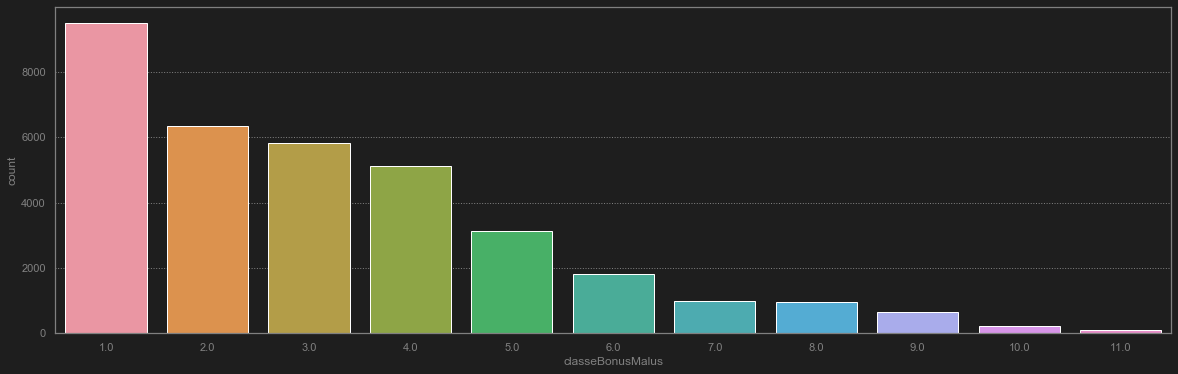

In [126]:
plt.figure(figsize = (20, 6))
sns.countplot(data = train_df, x = 'classeBonusMalus');

## $\rightarrow$ Creating target variable
- 1 $\rightarrow$ 7 : Good (1)
- 8 $\rightarrow$ 11 : Bad (0)

In [127]:
tmp = train_df['classeBonusMalus'].values
for i in range(len(tmp)):
    if tmp[i] < 8:
        tmp[i] = 1
    else:
        tmp[i] = 0

train_df['goodClient'] = tmp
train_df.drop(columns = ['classeBonusMalus'], inplace = True)

train_df.head()

,energie_ESS-GAZ GPL,energie_ESSENCE,energie_GASOIL,marque_ALFA-ROMEO,marque_ASTRA,marque_AUDI,marque_AUTOBIANCHI,marque_AVIA,marque_BAIC YINXIANG,marque_BEIJING,...,gouvernorat_Siliana,gouvernorat_Sousse,gouvernorat_Tataouine,gouvernorat_Tozeur,gouvernorat_Tunis,gouvernorat_Zaghouan,puissanceFiscal,codeTypePieceIdentite,anneesExpConduite,goodClient
policeId,,,,,,,,,,,,,,,,,,,,,
61587,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,5.0,1.0,38,1.0
61787,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,6.0,1.0,41,1.0
61830,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5.0,1.0,38,1.0
62859,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,5.0,1.0,20,1.0
63127,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,4.0,1.0,39,1.0


## $\rightarrow$ Target variable distribution

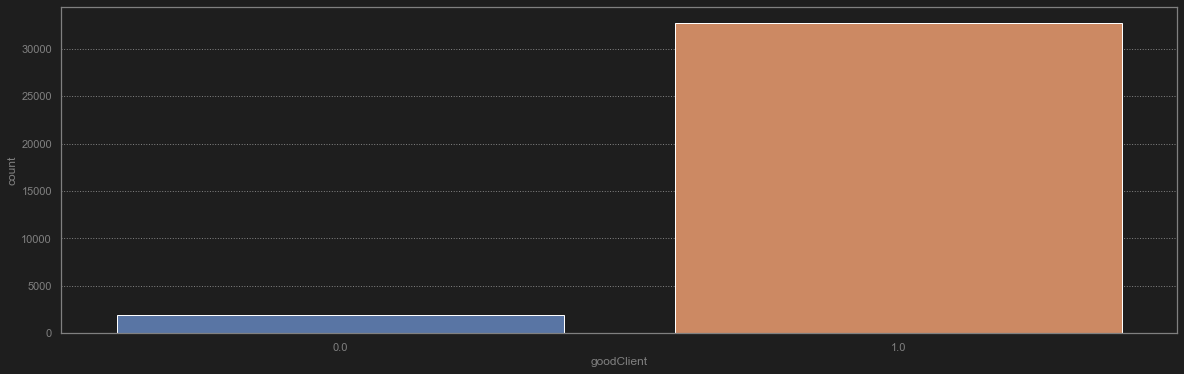

In [128]:
plt.figure(figsize = (20, 6))
sns.countplot(data = train_df, x = 'goodClient');

## $\rightarrow$ Resampling target variable (Down-sampling majority class)

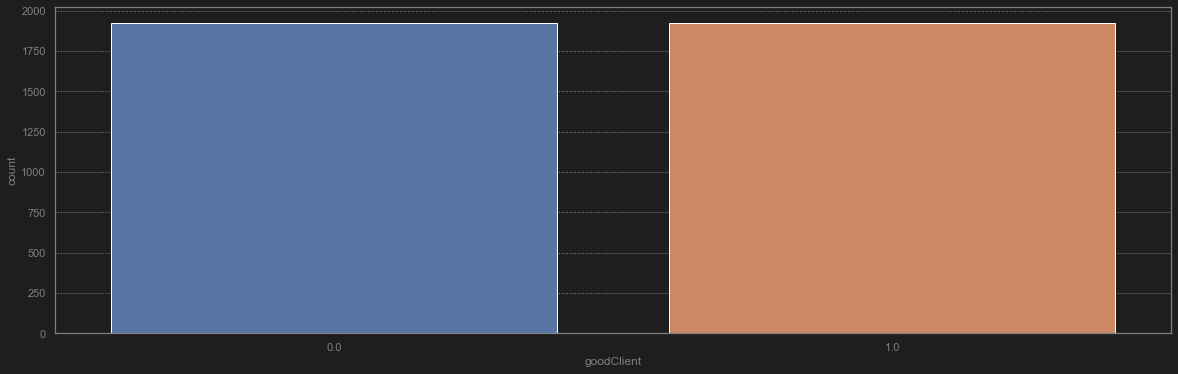

In [129]:
df_majority = train_df[train_df['goodClient'] == 1]
df_minority = train_df[train_df['goodClient'] == 0]

majority_resamp_df = resample(df_majority, replace = False, n_samples = 1927, random_state = 0)
resamp_df = pd.concat([majority_resamp_df, df_minority])

plt.figure(figsize = (20, 6))
sns.countplot(data = resamp_df, x = 'goodClient');

## Now our dataframe is ready for training models

<center>
    <h1>[Training Machine Learning models]</h1>
</center>

## $\rightarrow$ Splitting train and test data

In [130]:
X = resamp_df.iloc[:, :-1].values
y = resamp_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## $\rightarrow$ Scaling data

In [131]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## $\rightarrow$ K-Nearest Neighbors

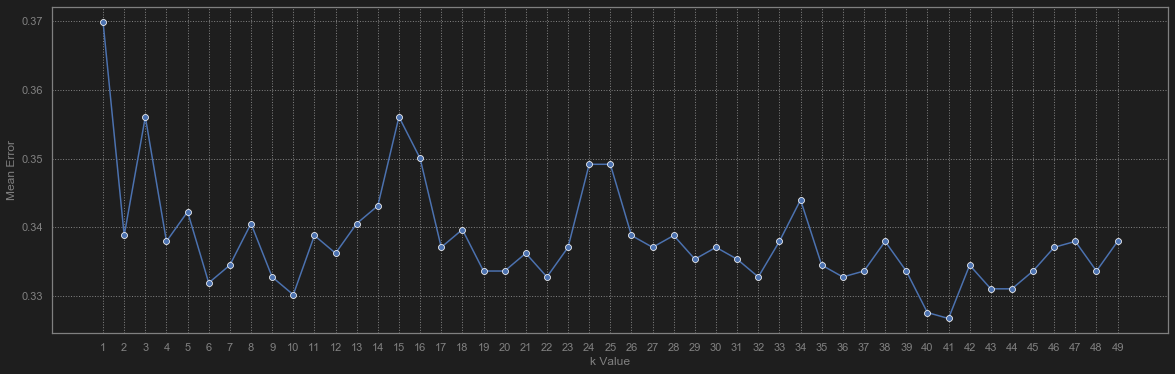

In [132]:
error = []

for i in range(1, 50):
    classifier = KNeighborsClassifier(n_neighbors = i)
    classifier.fit(X_train, y_train)
    yi_pred = classifier.predict(X_test)
    error.append(np.mean(yi_pred != y_test))
    print('Loop ' + str(i) + ' : done')
    clear_output(wait = True)

plt.figure(figsize = (20, 6))
plt.xticks(range(1, 50, 1))
plt.xlabel("k Value")
plt.ylabel("Mean Error")
sns.lineplot(range(1, 50), error, marker = 'o');

In [134]:
classifier = KNeighborsClassifier(n_neighbors = 41)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [135]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

         0.0       0.65      0.73      0.69       567
         1.0       0.70      0.62      0.66       590

    accuracy                           0.67      1157
   macro avg       0.68      0.67      0.67      1157
weighted avg       0.68      0.67      0.67      1157



## $\rightarrow$ Random Forest

In [92]:
classifier = RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0, class_weight = None,
                                    criterion = 'gini', max_depth = 110, max_features = 'auto', 
                                    max_leaf_nodes = None, max_samples = None, min_impurity_decrease = 0.0, 
                                    min_impurity_split = None, min_samples_leaf = 1, min_samples_split = 5, 
                                    min_weight_fraction_leaf = 0.0, n_estimators = 1200, n_jobs = None, 
                                    oob_score = False, random_state=None, verbose = 0, warm_start = False)

model = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

         0.0       0.64      0.74      0.69       567
         1.0       0.71      0.61      0.65       590

    accuracy                           0.67      1157
   macro avg       0.68      0.67      0.67      1157
weighted avg       0.68      0.67      0.67      1157



## $\rightarrow$ Logistic Regression

In [93]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'C': [0.01, 0.1, 1],
    'fit_intercept': [True, False],
}

rand_search = RandomizedSearchCV(LogisticRegression(), params, n_iter = 150, cv = 5)
rand_search.fit(X_train, y_train)

print(rand_search.best_estimator_)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [97]:
model = LogisticRegression(C = 0.01, class_weight = None, dual = False, fit_intercept = False, 
                           intercept_scaling = 1, l1_ratio = None, max_iter = 100, multi_class = 'auto', 
                           n_jobs = None, penalty = 'none', random_state = None, solver = 'lbfgs', 
                           tol = 0.0001, verbose = 0, warm_start = False)
model.fit(X_train, y_train)
y_pred_reg = model.predict(X_test)

print(classification_report(y_test, y_pred_reg))

precision    recall  f1-score   support

         0.0       0.64      0.74      0.69       567
         1.0       0.71      0.59      0.65       590

    accuracy                           0.67      1157
   macro avg       0.67      0.67      0.67      1157
weighted avg       0.67      0.67      0.67      1157



## $\rightarrow$ SVM

In [95]:
params = {
    'C': [0.01, 0.1, 1],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly'],
}

rand_search = RandomizedSearchCV(SVC(), params, n_iter = 30, cv = 5)
rand_search.fit(X_train, y_train)

print(rand_search.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [96]:
classifier = SVC(C = 1, break_ties = False, cache_size = 200, class_weight = None, 
                 coef0 = 0.0, decision_function_shape = 'ovr', degree = 3, gamma = 0.01, 
                 kernel = 'linear', max_iter = -1, probability = False, random_state = None, 
                 shrinking = True, tol = 0.001, verbose = False)

model = classifier.fit(X_train, y_train)
y_pred_svc = classifier.predict(X_test)

print(classification_report(y_test, y_pred_reg))

precision    recall  f1-score   support

         0.0       0.63      0.77      0.70       567
         1.0       0.72      0.57      0.63       590

    accuracy                           0.67      1157
   macro avg       0.68      0.67      0.67      1157
weighted avg       0.68      0.67      0.66      1157

